# Prediction of stock price

Data source: https://www.macrotrends.net/stocks/charts/AMZN/amazon/stock-price-history

In the project I will be doing the followings:
* Perform standard imports, load & plot the dataset
* Prepare data for an LSTM model
* Define the LSTM model, loss and optimization functions
* Train the model
* Evaluate the model on test data
* Visualisation of the results

The code in this project is based on a code created by Jose Marcial Portilla in 2019.

## Perform standard imports, load and plot the dataset

In [168]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [169]:
# load data
df = pd.read_csv('../input/amzn-stockprice/MacroTrends_Data_Download_AMZN.csv', index_col=0, parse_dates=True)

print(len(df))
print('-'*50)
display(df.head())
print('-'*50)
df.info()

6399
--------------------------------------------------


,open,high,low,close,volume
date,,,,,
1997-05-16,0.0933,0.0990,0.0854,0.0865,294000000
1997-05-19,0.0854,0.0885,0.0813,0.0854,122136000
1997-05-20,0.0865,0.0875,0.0818,0.0818,109344000
1997-05-21,0.0802,0.0823,0.0688,0.0714,377064000
1997-05-22,0.0719,0.0724,0.0656,0.0698,235536000


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6399 entries, 1997-05-16 to 2022-10-18
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6399 non-null   float64
 1   high    6399 non-null   float64
 2   low     6399 non-null   float64
 3   close   6399 non-null   float64
 4   volume  6399 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 300.0 KB


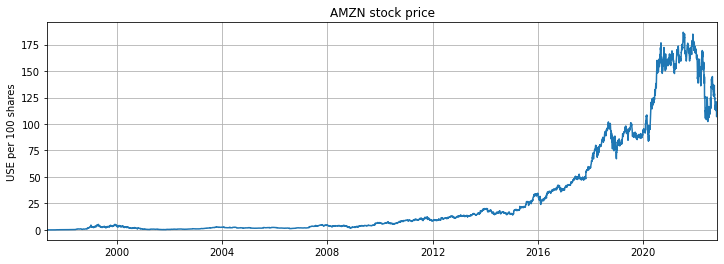

In [170]:
# Visulisation of data
plt.figure(figsize=(12, 4))
plt.title('AMZN stock price')
plt.ylabel('USE per 100 shares')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['close'])
plt.show()

In [171]:
# I take the data from 1990 to present for recent situation for our prediction in the short future.
df_filtered = df.loc[df.index >=  pd.to_datetime('2018-01-01')]

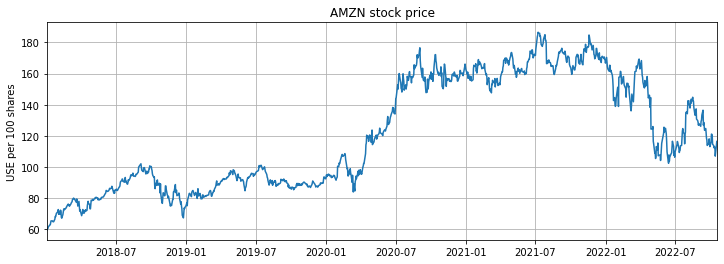

In [172]:
# Visulisation of data
plt.figure(figsize=(12, 4))
plt.title('AMZN stock price')
plt.ylabel('USE per 100 shares')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df_filtered['close'])
plt.show()

# Prepare the data
* divide the data into train and test sets
* normalize the training set
* prepare windowed seq/label tuples for an LSTM model

In [173]:
df_filtered=df_filtered[['close']]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1208 entries, 2018-01-02 to 2022-10-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   1208 non-null   float64
dtypes: float64(1)
memory usage: 18.9 KB


In [174]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_filtered['close'] = scaler.fit_transform(df_filtered['close'].values.reshape(-1,1))

# Check the results:
print(f'Max: {df_filtered.max()}, Min: {df_filtered.min()}')

Max: close    1.0
dtype: float64, Min: close   -1.0
dtype: float64


In [175]:
# Function of creating data for LSTM
# and dividing the data into train and validation sets 
def load_data(stock, look_back, val_percent):
    '''
    seq: sequential data, such as list of stock price data
    look_back: sequence length for prediction 
    Example: given seq [1 2 3 4] with given ws of 3, we get window [1 2 3 ] and label [4] in out 
    '''
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(val_percent * data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [176]:
val_percent = 0.1
look_back = 60 # sequence length
x_train, y_train, x_test, y_test = load_data(df_filtered, look_back, val_percent)

print('x_train.shape = ',x_train.shape) # the dimension is (number of batches, seq length, per day)
print('y_train.shape = ',y_train.shape) # the dimension is (number of batches, per day)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1033, 59, 1)
y_train.shape =  (1033, 1)
x_test.shape =  (115, 59, 1)
y_test.shape =  (115, 1)


In [177]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [178]:
# Check
display(y_train.size(), x_train.size())
print(y_train)

torch.Size([1033, 1])

torch.Size([1033, 59, 1])

tensor([[-0.8093],
        [-0.7968],
        [-0.8561],
        ...,
        [ 0.0200],
        [ 0.0234],
        [ 0.0196]])


# Define the model
Design a model that has a (1,64) LSTM layer and a (64,1) fully-connected linear layer.

In [179]:
# the shape of input seq for this model is assumed in (batches, seq length, 1)
# more information: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, nlayers=1, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = nlayers
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=nlayers, dropout=0.5, batch_first=True)
        
        # Add a fully-connected layer:
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, seq):
        # Initialize h0 and c0:
        h0 = torch.zeros(self.num_layers, seq.size(0), self.hidden_size, device=seq.device).requires_grad_()
        c0 = torch.zeros(self.num_layers, seq.size(0), self.hidden_size, device=seq.device).requires_grad_()
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(seq, (h0.detach(), c0.detach()))
        
        # the dimension of the out is (batch size, seq length, hidden size), batch size = number of batches
        out = self.fc(out[:, -1, :])
        
        return out

# Define loss and optimization functions
Define a loss function called "criterion" and an optimizer called "optimizer".<br>
You can use any functions you want, although we used MSELoss and Adam (learning rate of 0.001) respectively.

# Train the model

In [180]:
#check device
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'

In [181]:
# Set some variables and start training the model with all data
torch.manual_seed(7777)
device = get_device()
print(f'DEVICE: {device}')
model = LSTMnetwork().to(device)
display(model)

# Define loss and optimization functions
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

DEVICE: cuda


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTMnetwork(
  (lstm): LSTM(1, 128, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [182]:
# start training

import time
start_time = time.time()

n_epochs = 100
patience = 40
model_path = './deep_learinging_model.ckpt'

trn_losses = []
stale = 0
lowest_loss = float('inf')

model.train()
for i in range(n_epochs):
    i += 1
    trn_loss = 0

    # apply the model
    y_train_pred = model(x_train.to(device))

    # update parameters
    loss = criterion(y_train_pred, y_train.to(device))

    # Zero out gradient, backward pass, and update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # tally the number of loss and accuracy
    trn_loss = loss.item()
    trn_losses.append(trn_loss)

    # print statement
    print(f'[{i} / {n_epochs}] epochs   MSE Loss: {trn_loss}')

    # if the model improves, save a checkpoint at this epoch
    if trn_loss < lowest_loss:
        lowest_loss = trn_loss
        torch.save(model.state_dict(), model_path)
        print('saving model with loss {:.3f}'.format(trn_loss))
        stale = 0
    else:
        stale += 1
    if stale > patience:
        print(f"No improvment in the last {patience} consecutive epochs, early stoppin")
        break

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

[1 / 100] epochs   MSE Loss: 0.3388098478317261
saving model with loss 0.339
[2 / 100] epochs   MSE Loss: 0.326233834028244
saving model with loss 0.326
[3 / 100] epochs   MSE Loss: 0.31386807560920715
saving model with loss 0.314
[4 / 100] epochs   MSE Loss: 0.3015054762363434
saving model with loss 0.302
[5 / 100] epochs   MSE Loss: 0.28897547721862793
saving model with loss 0.289
[6 / 100] epochs   MSE Loss: 0.27609628438949585
saving model with loss 0.276
[7 / 100] epochs   MSE Loss: 0.26266759634017944
saving model with loss 0.263
[8 / 100] epochs   MSE Loss: 0.24846531450748444
saving model with loss 0.248
[9 / 100] epochs   MSE Loss: 0.23321190476417542
saving model with loss 0.233
[10 / 100] epochs   MSE Loss: 0.21653534471988678
saving model with loss 0.217
[11 / 100] epochs   MSE Loss: 0.1979207992553711
saving model with loss 0.198
[12 / 100] epochs   MSE Loss: 0.17665503919124603
saving model with loss 0.177
[13 / 100] epochs   MSE Loss: 0.15178048610687256
saving model wit

In [183]:
y_train.size()

torch.Size([1033, 1])

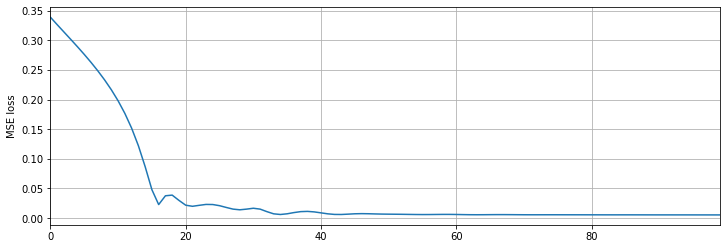

In [184]:
# visulisation of loss
plt.figure(figsize=(12,4))
plt.ylabel('MSE loss')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(trn_losses)
plt.show()

## Evaluate the model using the validation set

In [185]:
# predict future
model.eval()
y_test_pred = model(x_test.to(device))

In [186]:
# inverse transform
y_train_pred = scaler.inverse_transform(y_train_pred.cpu().detach().numpy())
y_train = scaler.inverse_transform(y_train.cpu().detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scaler.inverse_transform(y_test.cpu().detach().numpy())

In [187]:
# calculate root mean squared error
import math
from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print(f'Train Score: {trainScore:.3f} RMSE')
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print(f'Test Score: {testScore:.3f} RMSE')

Train Score: 4.684 RMSE
Test Score: 8.929 RMSE


### Plot the prediction

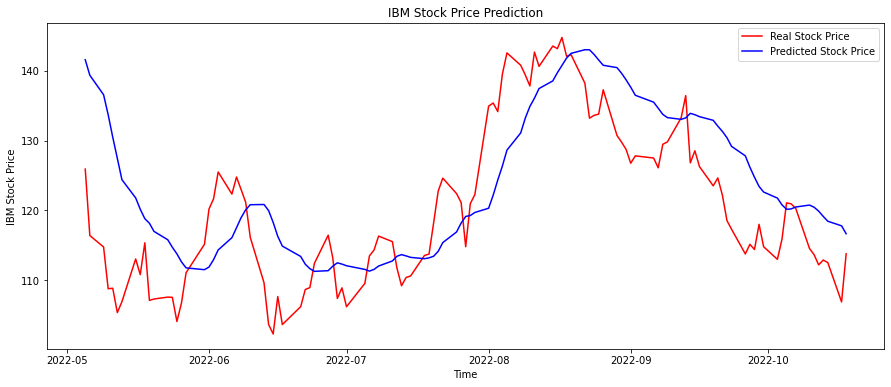

In [188]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_filtered[len(df_filtered)-len(y_test):].index, y_test, color='red', label='Real Stock Price')
axes.plot(df_filtered[len(df_filtered)-len(y_test):].index, y_test_pred, color='blue', label='Predicted Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.savefig('ibm_pred.png')
plt.show()

# Forecast the unknown future

In [189]:
# using the whole data set to run the model then we can get the forecasting stock price.